In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import exploratory_sncosmo_analysis_functions as eaf

sncosmo_fixed_z_pdf = pd.read_csv("/Users/kai/Desktop/Coding/Python/Swinburne/SALT2_analysis/data/raw/fixed_z_results.csv")

flux_fits_pdf = pd.read_csv("/Users/kai/Desktop/Coding/Python/Swinburne/SALT2_analysis/data/raw/flux_fits_data.csv")
sncosmo_pdf = pd.read_csv("/Users/kai/Desktop/Coding/Python/Swinburne/SALT2_analysis/data/raw/general_results.csv")
flux_fits_pdf_unique = flux_fits_pdf.drop_duplicates(subset="object id")

In [2]:
eval_arr   = sncosmo_pdf[["ndof", "min chi2", "p-val"]].to_numpy()
relevant_params = sncosmo_pdf[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
ndof, min_chi2, p_vals = eval_arr.T
reduced_chi2 = min_chi2 / ndof
z, x1, c, sig_x1, sig_c = relevant_params.T

/var/folders/nh/74hv8v0x06jc83ddd62dz8mh0000gn/T/ipykernel_94731/612983576.py:4: RuntimeWarning:

divide by zero encountered in divide



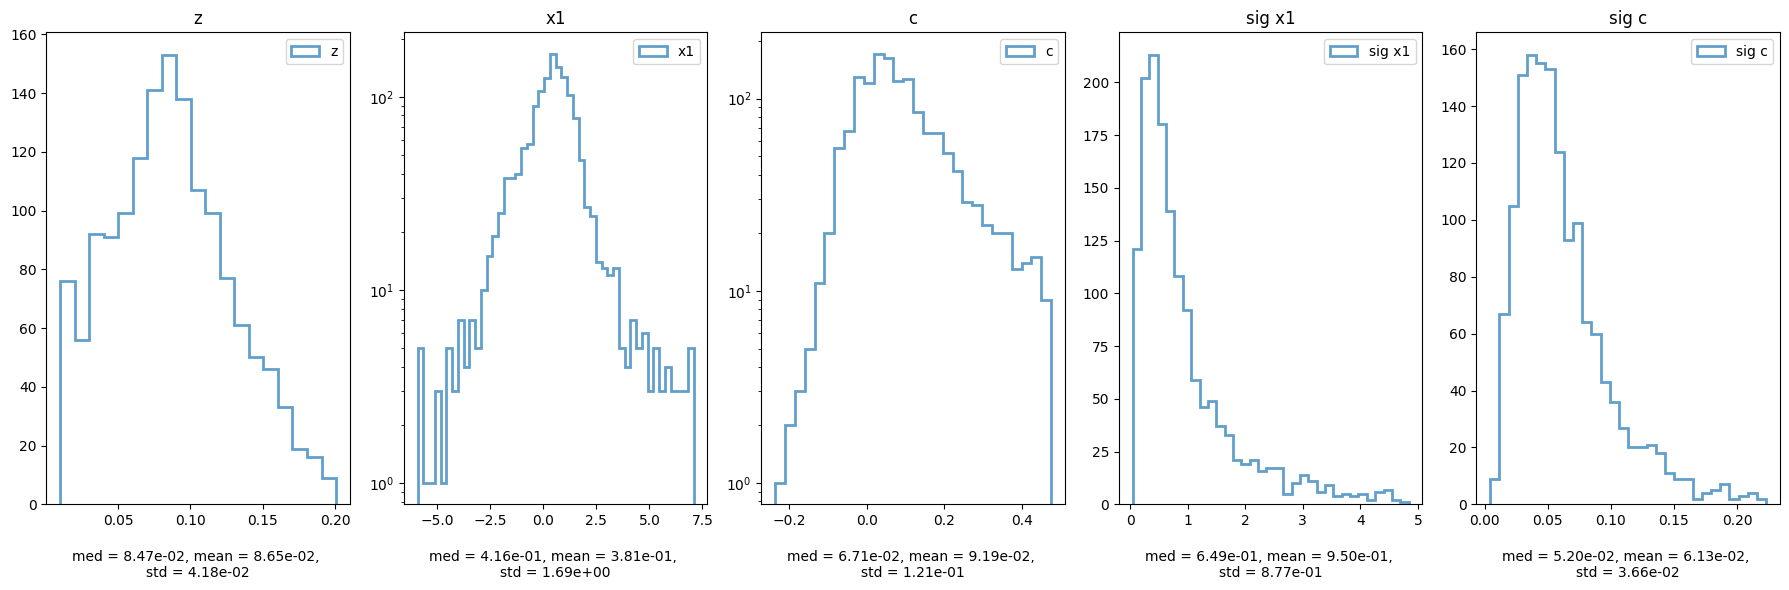

In [3]:
# Plotting histograms of relevant parameters

z, x1, c, sig_x1, sig_c = zip(*eaf.remove_outliers(relevant_params))

eaf.plot_sncosmo_param_hist([
    (z, "z", False, False, None),
    (x1, "x1", False, True, None),
    (c, "c", False, True, None),
    (sig_x1, "sig x1", False, False, None),
    (sig_c, "sig c", False, False, None),
], 18, 6)

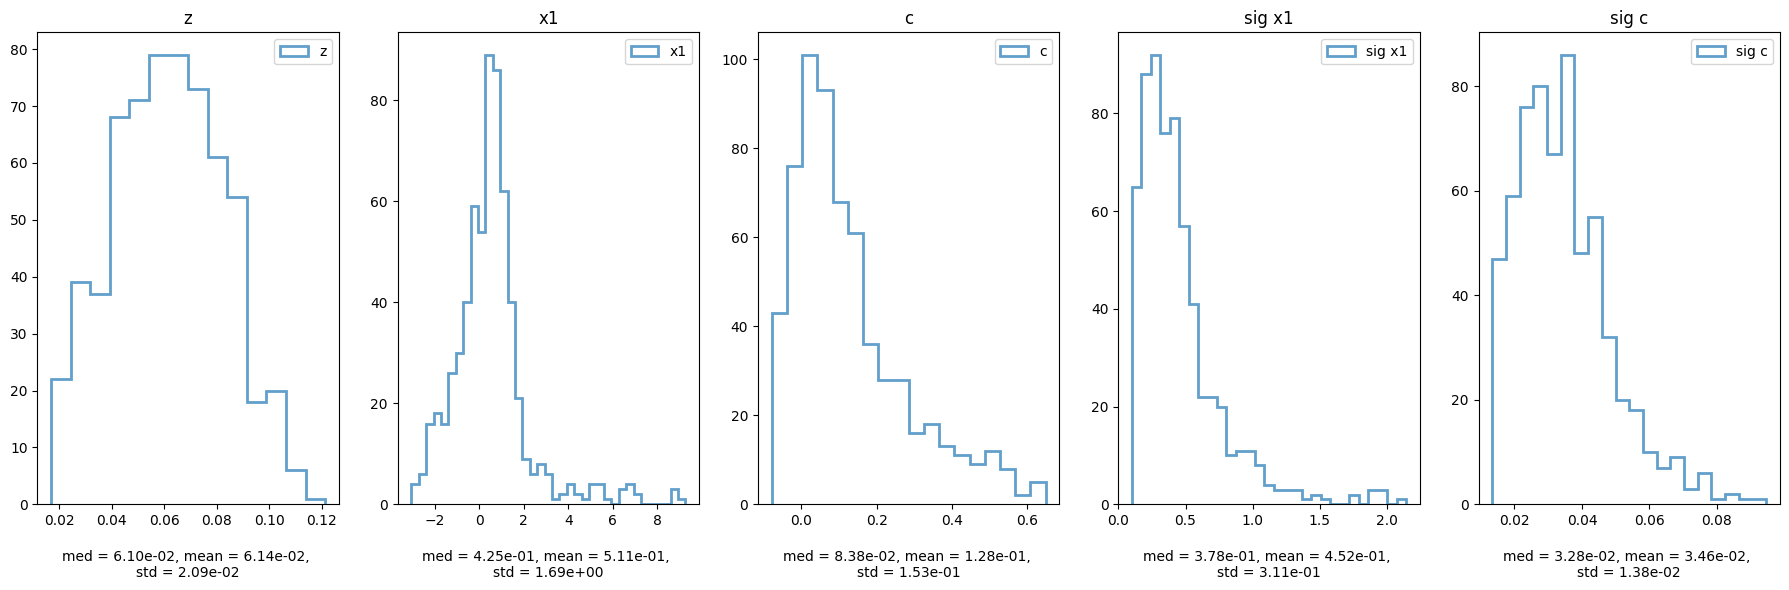

In [4]:
fixed_z_params = sncosmo_fixed_z_pdf[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()

percentiles = [2, 98]

z, x1, c, sig_x1, sig_c = zip(*eaf.remove_outliers(fixed_z_params, *percentiles))

eaf.plot_sncosmo_param_hist([
    (z, "z", False, False, None),
    (x1, "x1", False, False, None),
    (c, "c", False, False, None),
    (sig_x1, "sig x1", False, False, None),
    (sig_c, "sig c", False, False, None),
], 18, 6)

In [5]:
print(sncosmo_fixed_z_pdf["tns_class"].unique())

['SN Ia-91T-like' 'SN Ia' 'SN II' 'SN IIn' 'SN IIb' 'SN Ib' 'SN Ia-pec'
 'SN Ic-BL' 'SN Ic' 'SN II-pec' 'SN Iax[02cx-like]' 'SLSN-I'
 'SN Ia-91bg-like' 'SN Ia-CSM' 'SLSN-II' 'SN' 'SN Ib/c' 'SN Ibn']


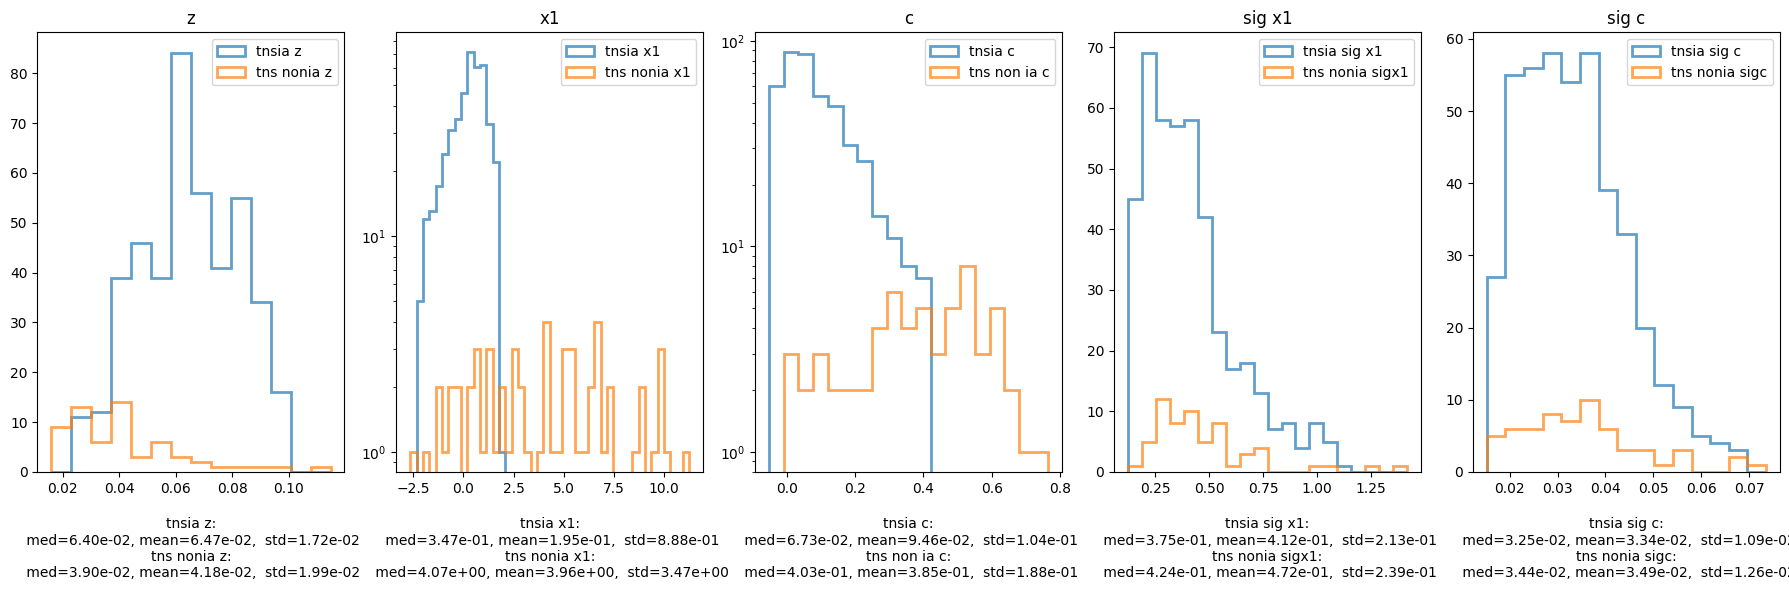

In [35]:
# Stratifying by TNS classification:
ia_types = {'SN Ia', 'SN Ia-91T-like', 'SN Iax[02cx-like]', 'SN Ia-pec'}
sncosmo_pdf = sncosmo_pdf.drop(columns="tns_class", errors="ignore").merge(
    sncosmo_fixed_z_pdf[["object id","tns_class"]],
    on="object id",
    how="left"
)


merged_df = pd.merge(
    flux_fits_pdf_unique[["object id","color change"]],
    sncosmo_fixed_z_pdf[["object id", "tns_class", "z", "x1", "c", "sig x1", "sig c"]],
    on="object id",
    how="inner"
)

percentiles = [5, 95]
maskTNSIa = merged_df["tns_class"].isin(ia_types)
maskNonIaTNS = ~merged_df["tns_class"].isin(ia_types) & ~merged_df["tns_class"].isna()

merged_tnsia = merged_df[maskTNSIa] 
merged_tns_nonia = merged_df[maskNonIaTNS]

tnsia_params = merged_tnsia[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
tnsia_z, tnsia_x1, tnsia_c, tnsia_sigx1, tnsia_sigc = zip(*eaf.remove_outliers(tnsia_params, *percentiles))

no_tnsia_params = merged_tns_nonia[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
tns_nonia_z, tns_nonia_x1, tns_nonia_c, tns_nonia_sigx1, tns_nonia_sigc = zip(*eaf.remove_outliers(no_tnsia_params, *percentiles))

tnsia_pairs = [
    [tnsia_z, tns_nonia_z, ["tnsia z", "tns nonia z"], "z", False, False, None],
    [tnsia_x1, tns_nonia_x1, ["tnsia x1", "tns nonia x1"], "x1", False, True, None],
    [tnsia_c, tns_nonia_c, ["tnsia c", "tns non ia c"], "c", False, True, None],
    [tnsia_sigx1, tns_nonia_sigx1, ["tnsia sig x1", "tns nonia sigx1"], "sig x1", False, False, None],
    [tnsia_sigc, tns_nonia_sigc, ["tnsia sig c", "tns nonia sigc"], "sig c", False, False, None],
]

eaf.plot_sncosmo_param_hist(tnsia_pairs, 18, 6, data_groups=True, nrows=1, ncols=5)

TNS ias tend to have higher redshifts (probably sampling bias). TNS Ias tend to have lower $|x_1|$ values, while non ias tend to lean slightly more towards positive values. TNS Ias also have C values that follow a left skewed gaussian with a strong peak around zer0, while non ias tend have more spread out values of C, but still slightly skewed right with a peak around 0.5. TNS Ias tend to have slightly lower values $\sigma C$, but not substantially. Non ias tend to have a more even $\sigma C$ distribution, while the Ias have a left skewed gaussian with a strong peak ~0.3.

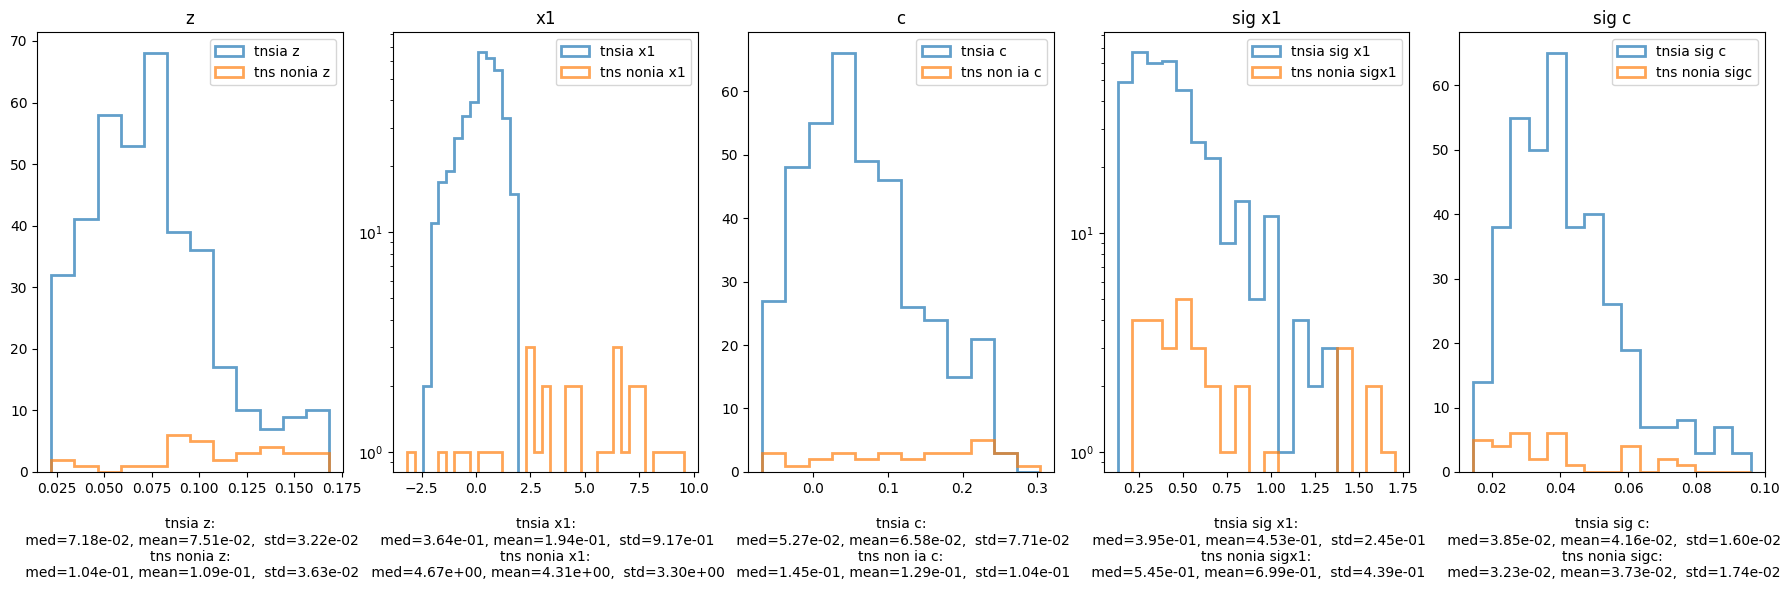

In [31]:
# Now looking at distribution of TNS Ias and non Ias for -0.3 < c < 0.3
percentiles = [5, 95]

tnsia_params = merged_tnsia[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
tnsia_z, tnsia_x1, tnsia_c, tnsia_sigx1, tnsia_sigc = zip(*eaf.remove_outliers(eaf.remove_outside_range(tnsia_params, -0.3, 0.3, 'c'), *percentiles))

no_tnsia_params = merged_tns_nonia[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
tns_nonia_z, tns_nonia_x1, tns_nonia_c, tns_nonia_sigx1, tns_nonia_sigc = zip(*eaf.remove_outliers(eaf.remove_outside_range(no_tnsia_params, -0.3, 0.3, 'c'), *percentiles))

tnsia_pairs = [
    [tnsia_z, tns_nonia_z, ["tnsia z", "tns nonia z"], "z", False, False, None],
    [tnsia_x1, tns_nonia_x1, ["tnsia x1", "tns nonia x1"], "x1", False, True, None],
    [tnsia_c, tns_nonia_c, ["tnsia c", "tns non ia c"], "c", False, False, None],
    [tnsia_sigx1, tns_nonia_sigx1, ["tnsia sig x1", "tns nonia sigx1"], "sig x1", False, True, None],
    [tnsia_sigc, tns_nonia_sigc, ["tnsia sig c", "tns nonia sigc"], "sig c", False, False, None],
]

eaf.plot_sncosmo_param_hist(tnsia_pairs, 18, 6, data_groups=True, nrows=1, ncols=5)

In [8]:
maskColorRange = (merged_tns_nonia["c"] >= -0.3) & (merged_tns_nonia["c"] <= 0.3)

sn_types = merged_tns_nonia[maskColorRange]["tns_class"]

sn_counts_dict = sn_types.value_counts().to_dict()
print(sn_counts_dict)

{'SN II': 18, 'SN IIn': 7, 'SN Ic': 3, 'SLSN-I': 2, 'SN Ic-BL': 2, 'SN IIb': 1, 'SLSN-II': 1, 'SN Ib': 1, 'SN Ibn': 1}


Most of the contaminants in the $-0.3 < C < 0.3$ range are SN II's appearing 6 times, with SN Ic's and SN IIn's appearing 1/3 as often. After that there is 1 of each Sn Ib, SLSN-I, SLSN-II, SN IC-BL.

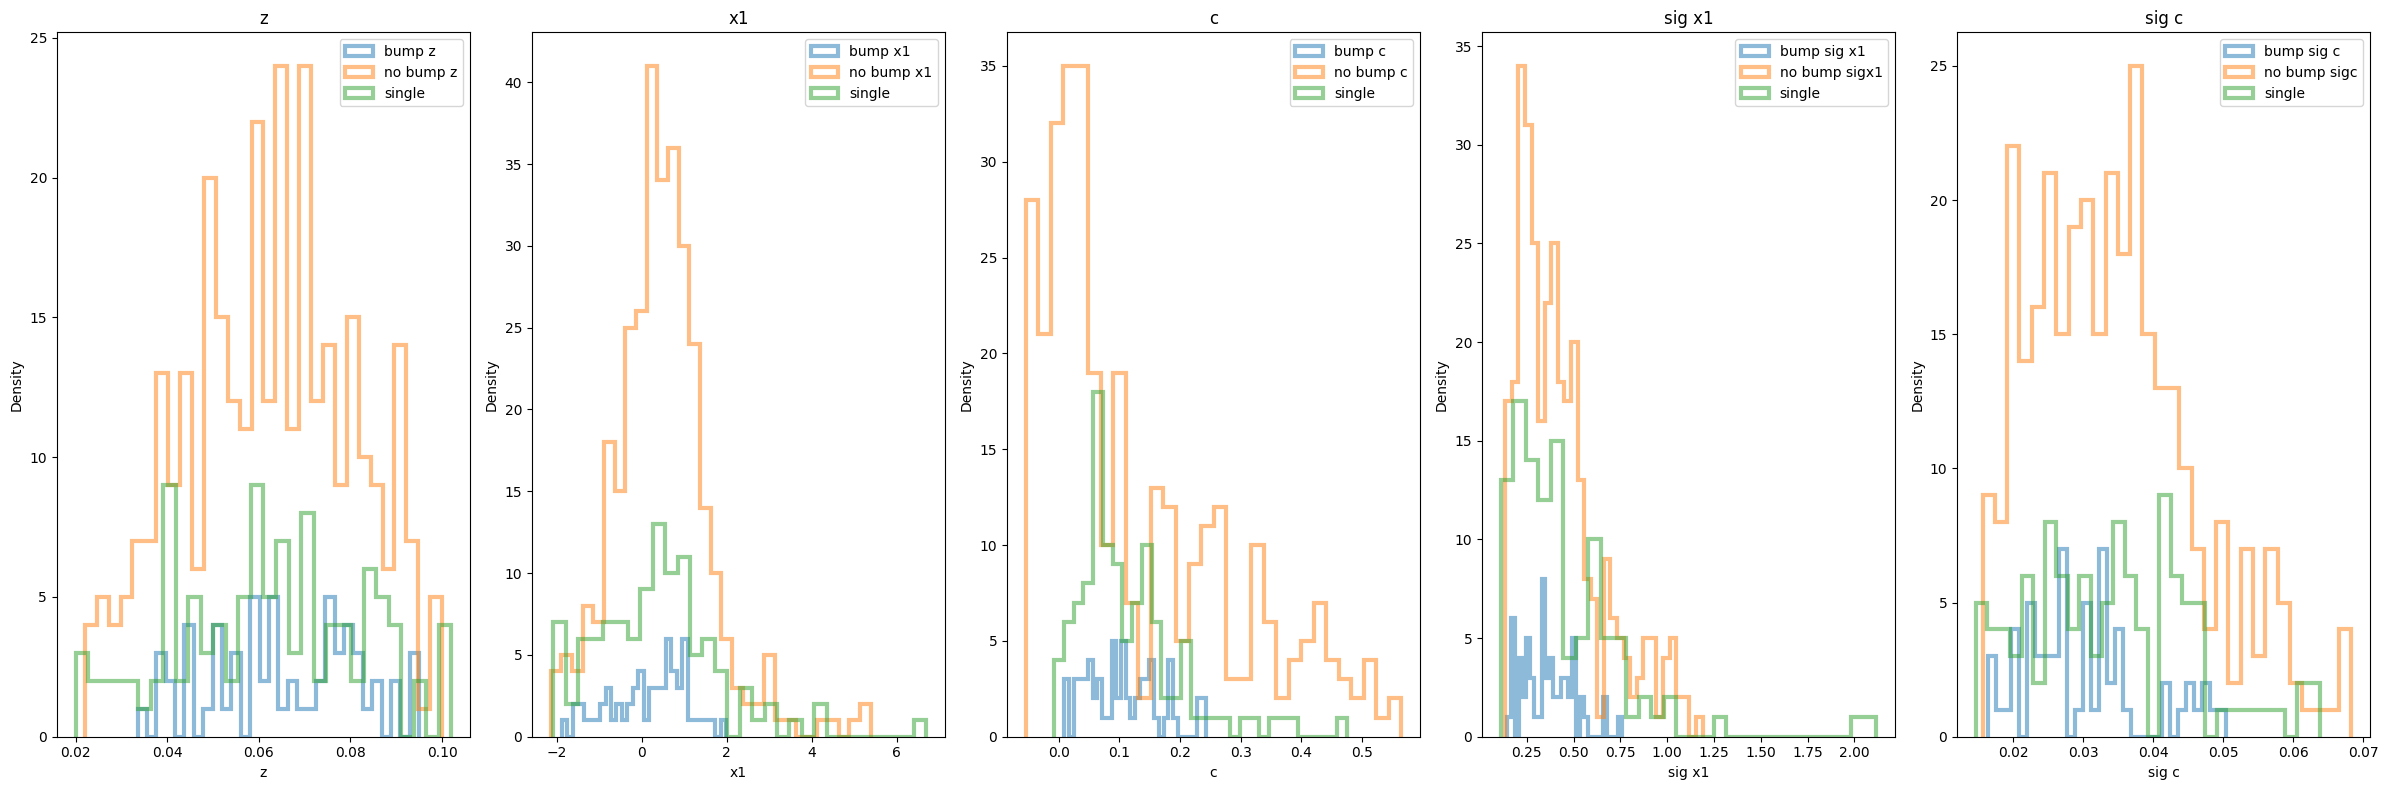

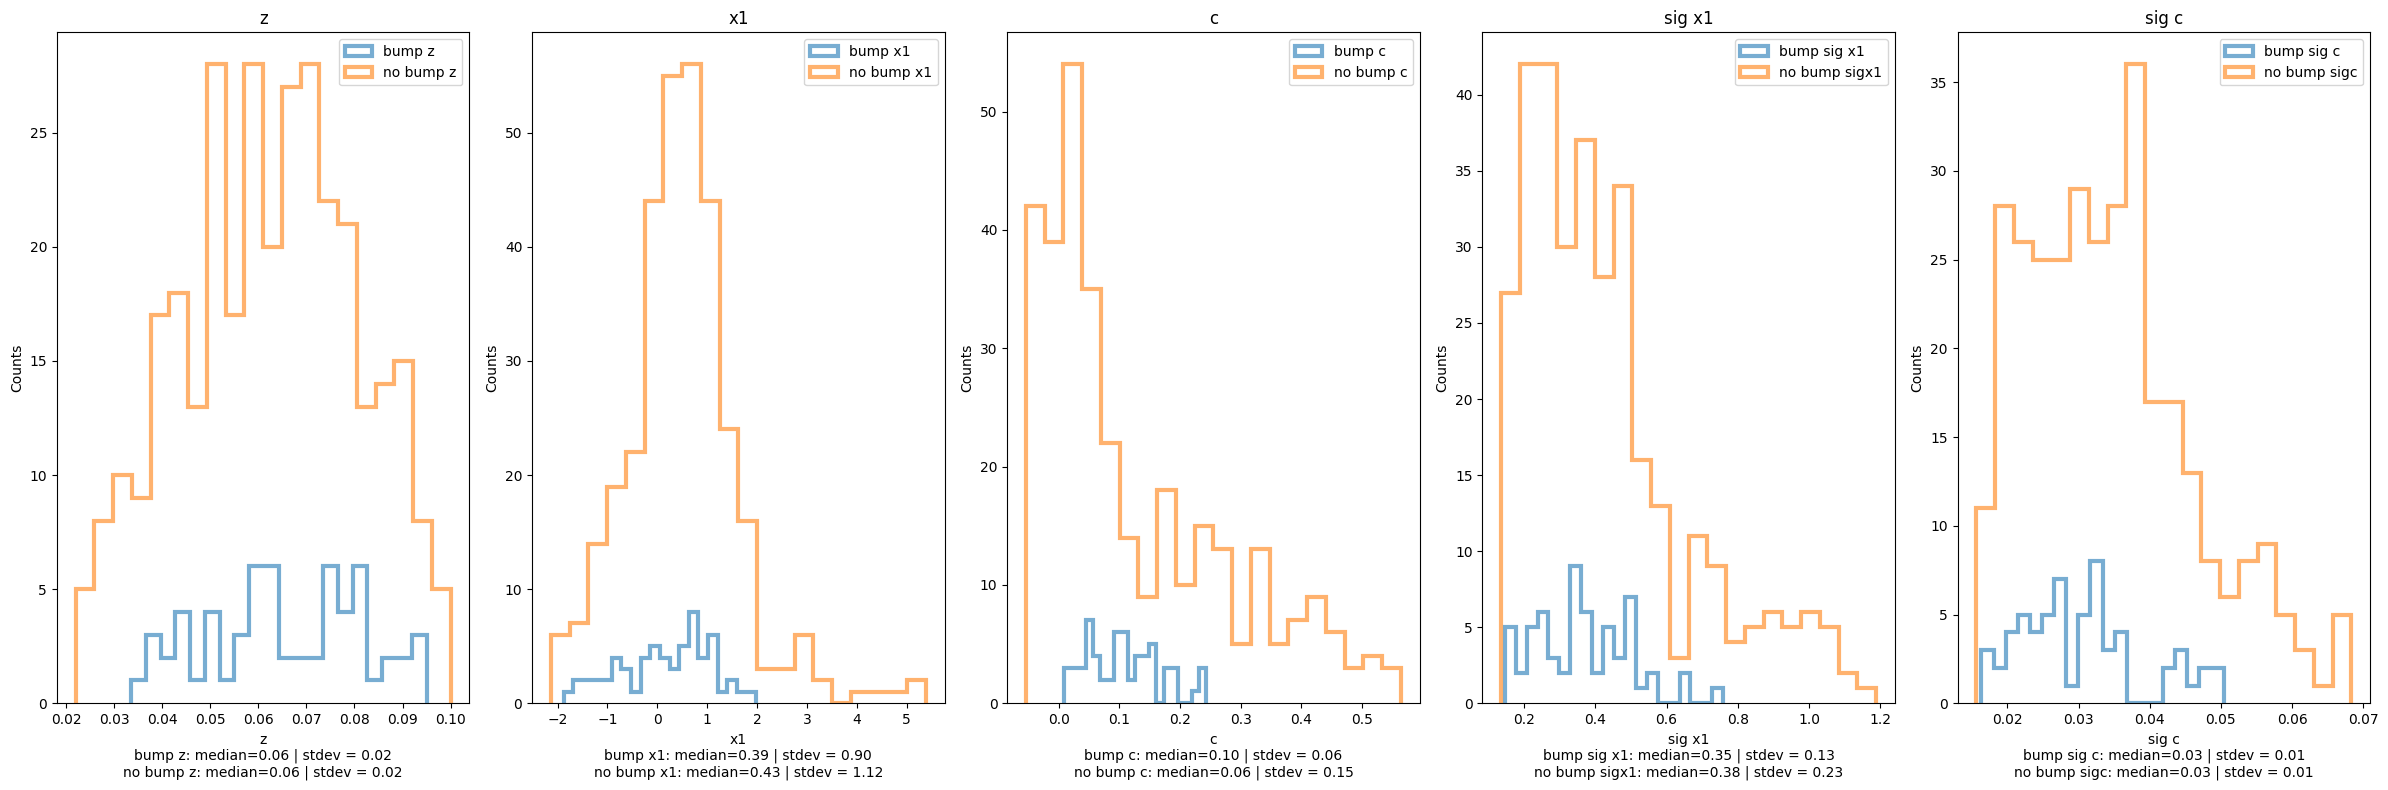

In [65]:
# Stratifying by bumps:
maskBump = merged_df["color change"] == 'bump'
maskSingle = merged_df["color change"] == 'single'
maskNone = merged_df["color change"] == 'none'

merged_bump = merged_df[maskBump] 
merged_nb = merged_df[maskNone]
merged_single = merged_df[maskSingle]
percentiles = [5, 95]

bump_params = merged_bump[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
bump_z, bump_x1, bump_c, bump_sigx1, bump_sigc = zip(*eaf.remove_outliers(bump_params, *percentiles))

nb_params = merged_nb[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
nb_z, nb_x1, nb_c, nb_sigx1, nb_sigc = zip(*eaf.remove_outliers(nb_params, *percentiles))

single_params = merged_single[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
single_z, single_x1, single_c, single_sigx1, single_sigc = zip(*eaf.remove_outliers(single_params, *percentiles))

bump_pairs = [
    [bump_z, nb_z, ["bump z", "no bump z"], "z", False, False, None],
    [bump_x1, nb_x1, ["bump x1", "no bump x1"], "x1", False, False, None],
    [bump_c, nb_c, ["bump c", "no bump c"], "c", False, False, None],
    [bump_sigx1, nb_sigx1, ["bump sig x1", "no bump sigx1"], "sig x1", False, False, None],
    [bump_sigc, nb_sigc, ["bump sig c", "no bump sigc"], "sig c", False, False, None],
]

import matplotlib.pyplot as plt

# Parallel list of single-variable arrays, same order as bump_pairs
single_vars = [
    single_z,
    single_x1,
    single_c,
    single_sigx1,
    single_sigc
]

fig, axes = plt.subplots(1, len(bump_pairs), figsize=(24, 8))

for ax, (bump, nb, labels, title, logx, logy, xlim), single in zip(axes, bump_pairs, single_vars):
    # Plot bump vs non-bump vs single
    ax.hist(bump, bins=30, alpha=0.5, label=labels[0], histtype='step', linewidth=3)
    ax.hist(nb, bins=30, alpha=0.5, label=labels[1], histtype='step', linewidth=3)
    ax.hist(single, bins=30, alpha=0.5, label="single", histtype='step', linewidth=3)
    
    # Title and labels
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.set_ylabel("Density")
    
    # Axis scaling
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    
    # Optional x limits
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.legend()

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(bump_pairs), figsize=(24, 8))

for ax, (bump, nb, labels, title, logx, logy, xlim) in zip(axes, bump_pairs):
    # Plot bump vs non-bump as histograms
    ax.hist(bump, bins=20, alpha=0.6, label=labels[0], histtype='step', linewidth=3)
    ax.hist(nb, bins=20, alpha=0.6, label=labels[1], histtype='step', linewidth=3)

    # Compute summary stats
    summaries = []
    for arr, label in zip([bump, nb], labels):
        arr = np.asarray(arr)
        if len(arr) > 0:
            median = np.median(arr)
            stdev = np.std(arr)
            summaries.append(f"{label}: median={median:.2f} | stdev = {stdev:.2f}")

    # Title and labels
    ax.set_title(title)
    ax.set_xlabel(title + "\n" + "\n".join(summaries))  # append stats to xlabel
    ax.set_ylabel("Counts")

    # Axis scaling
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    # Optional x limits
    if xlim is not None:
        ax.set_xlim(xlim)

    ax.legend()

plt.tight_layout()
plt.show()


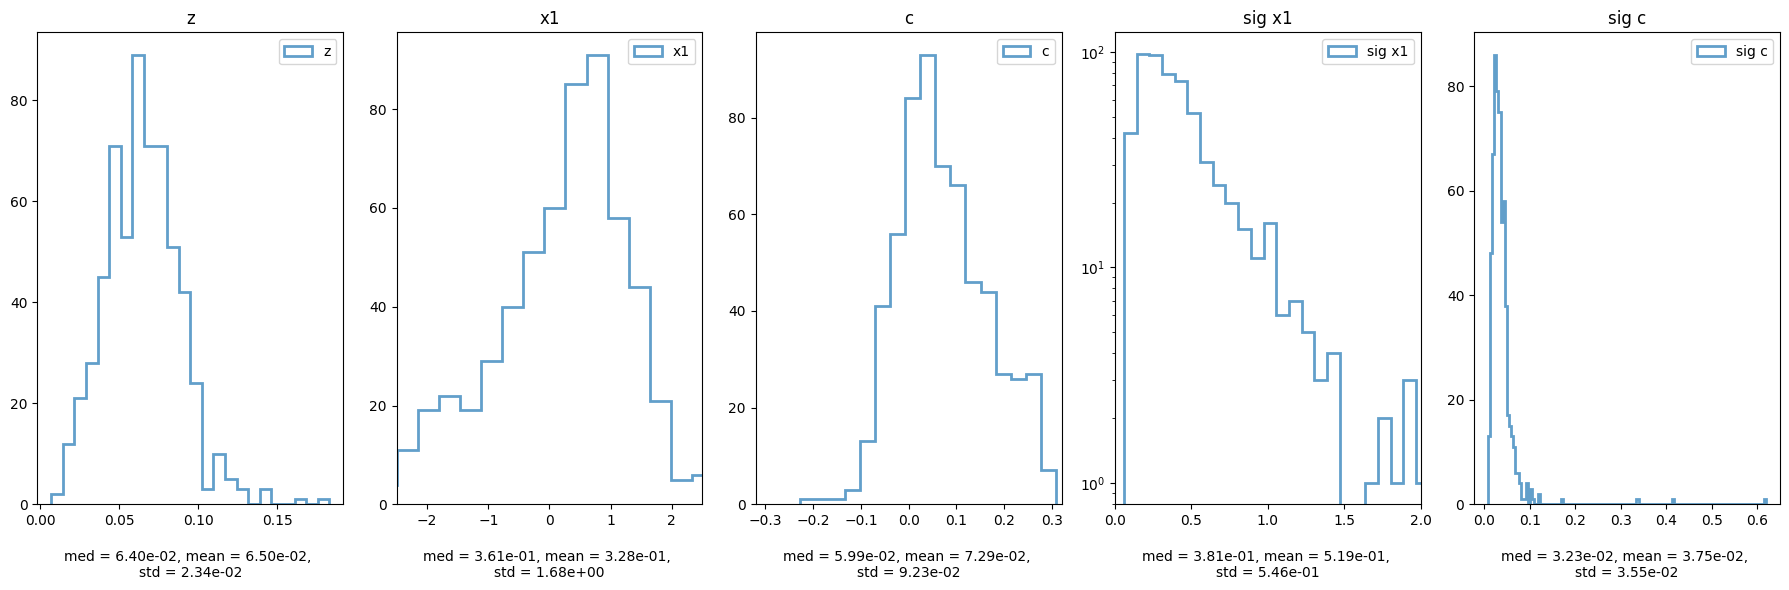

In [56]:
# Plotting parameters only for -0.3 < c < 0.3.
percentiles = [10, 90]
fixed_z_params = sncosmo_fixed_z_pdf[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
z, x1, c, sig_x1, sig_c = zip(*eaf.remove_outside_range(fixed_z_params, -0.3, 0.3, "c"))

eaf.plot_sncosmo_param_hist([
    (z, "z", False, False, None),
    (x1, "x1", False, False, (-2.5, 2.5)),
    (c, "c", False, False, (-0.32, 0.32)),
    (sig_x1, "sig x1", False, True, (0, 2)),
    (sig_c, "sig c", False, False, None),
], 18, 6)

# Statifying for bumps 

bump_params = merged_bump[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
bump_z, bump_x1, bump_c, bump_sigx1, bump_sigc = zip(*eaf.remove_outside_range(bump_params, -0.3, 0.3, "c"))

nb_params = merged_nb[["z", "x1", "c", "sig x1", "sig c"]].to_numpy()
nb_z, nb_x1, nb_c, nb_sigx1, nb_sigc = zip(*eaf.remove_outside_range(nb_params, -0.3, 0.3, "c"))

bump_pairs = [
    [bump_z, nb_z, ["bump z", "nb z"], "z", False, False, None],
    [bump_x1, nb_x1, ["bump x1", "nb x1"], "x1", False, False, (-2.5, 2.5)],
    [bump_c, nb_c, ["bump c", "nb c"], "c", False, False, (-0.32, 0.32)],
    [bump_sigx1, nb_sigx1, ["bump sig x1", "nb sigx1"], "sig x1", False, False, (0, 2)],
    [bump_sigc, nb_sigc, ["bump sig c", "nb sigc"], "sig c", False, True, None],
]






When -0.3 < c < 0.3, the color distribution is a slightly right skewed gaussian peaking around 0.05. While $x_1$ is heavily concentrated around 0, with most of its main distribution lying between -2.5 and 2.5. Bumps tend to have lower $\sigma x_1$, and $\sigma C$. The $x_1$ values are more evenly distributed for bumps, while the no bumps follow a right skewed gaussian with a strong peak at ~0.2.